In [1]:
# !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
# !python rapidsai-csp-utils/colab/pip-install.py

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
Installing RAPIDS remaining 25.04 libraries
Using Python 3.11.13 environment at: /usr
Resolved 173 packages in 11.56s
 Downloaded cuproj-cu12
 Downloaded shapely
 Downloaded datashader
 Downloaded dask
 Downloaded libkvikio-cu12
 Downloaded ucx-py-cu12
 Downloaded cudf-cu12
 Downloaded cucim-cu12
 Downloaded cuspatial-cu12
 Downloaded rmm-cu12
 Downloaded pylibcugraph-cu12
 Downloaded cugraph-cu12
 Downloaded librmm-cu12
 Downloaded cuml-cu12
 Downloaded bokeh
 Downloaded libraft-cu12
 Downloaded pylibcudf-cu12
 Downloaded libcuspatial-cu12
 Downloaded raft-dask-cu12
 Downloaded libcuml-cu12
 Downloaded libcudf-cu12
 Downloaded libcuvs-cu12
 Downloaded libcugraph-cu12
Prepared 50 packages in 1m 12s
Uninstalled 29 packages in 906ms
Installed 52 packages in 415ms
 + arrow==1.3.0
 - bokeh==3.7.3
 + bokeh==3.6.3
 + cucim-cu12==25.4.0
 - cudf-cu12==25.2.1 (from https://pypi.nvidia.com/cudf-cu12/cudf_c

In [2]:
# !pip install umap-learn hdbscan geopandas matplotlib seaborn numpy pandas umap-learn scikit-learn

In [3]:
"""
This is a notebook to walkthrough the process of clustering the combined data.

NOTE: For speedup, this notebook was ran in Google Colab. File paths will change
slightly as a result.
"""
# NOTE: These are some commands I had to run at the top of this notebook, to
# make it work in Google Colab.
# !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
# !python rapidsai-csp-utils/colab/pip-install.py
# !pip install umap-learn hdbscan geopandas matplotlib seaborn numpy pandas \
# umap-learn scikit-learn

# Load cuml extension to use a dGPU for calculations (which lead to much faster
# computation times)
%load_ext cuml.accel

import geopandas as gpd
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap

from sklearn.preprocessing import StandardScaler

cuML: Installed accelerator for sklearn.
cuML: Installed accelerator for umap.
cuML: Installed accelerator for hdbscan.
cuML: Successfully initialized accelerator.


In [4]:
# Import data from previous notebook
df = pd.read_pickle("merged_data_2022-07-08_to_2025-07-07.pkl")
# df = pd.read_pickle("data/merged_data_2022-07-08_to_2025-07-07.pkl")
print(df.head())

  dispatch_date       dispatch_time            address_block        lat  \
0    2025-05-02 2025-07-08 23:44:00      1100 BLOCK S 4TH ST  39.934248   
2    2025-04-23 2025-07-08 18:32:00     1700 BLOCK N 32ND ST  39.983588   
3    2025-04-24 2025-07-08 00:47:00  1300 BLOCK W Venango St  40.007425   
4    2025-02-26 2025-07-08 20:16:00      400 BLOCK N 35TH ST  39.961642   
5    2025-04-13 2025-07-08 03:15:00      5100 BLOCK N 5TH ST  40.029310   

         lon  district_01  district_02  district_03  district_05  district_06  \
0 -75.150833        False        False         True        False        False   
2 -75.186199        False        False        False        False        False   
3 -75.149843        False        False        False        False        False   
4 -75.192723        False        False        False        False        False   
5 -75.132056        False        False        False        False        False   

   ...  max_temp_f  min_temp_f  pop_total  income_median  medi

The first significant step is to scale our data, as clustering is based on distance. This is to avoid
features that are naturally greater in range, take higher importance/precedence when clustered.

In [5]:
# Initialize StandardScaler and config it to output a DataFrame
scaler = StandardScaler()
scaler.set_output(transform='pandas')

# Extract the columns to scale
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
# NOTE: I do not want to scale the sinusoidal features as they are already in the desired range
cols_to_scale = [
    col for col in numeric_cols
    if '_sin' not in col and '_cos' not in col
]

# Fit and transform the data
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

# Print the scaled data as sanity check
print(df.head())

  dispatch_date       dispatch_time            address_block       lat  \
0    2025-05-02 2025-07-08 23:44:00      1100 BLOCK S 4TH ST -1.407757   
2    2025-04-23 2025-07-08 18:32:00     1700 BLOCK N 32ND ST -0.323392   
3    2025-04-24 2025-07-08 00:47:00  1300 BLOCK W Venango St  0.200477   
4    2025-02-26 2025-07-08 20:16:00      400 BLOCK N 35TH ST -0.805715   
5    2025-04-13 2025-07-08 03:15:00      5100 BLOCK N 5TH ST  0.681454   

        lon  district_01  district_02  district_03  district_05  district_06  \
0 -0.066541        False        False         True        False        False   
2 -0.628440        False        False        False        False        False   
3 -0.050807        False        False        False        False        False   
4 -0.732081        False        False        False        False        False   
5  0.231798        False        False        False        False        False   

   ...  max_temp_f  min_temp_f  pop_total  income_median  median_age  \
0 

Now, the data is ready for applying UMAP. This is a non-linear dimensionality
reduction algorithm, based on topology (allowing it to capture those non-linear patterns). This is
used, as clustering our data with over 80 columns can easily lead to the curse of dimensionality,
leading to much higher computational time and overfitting.

However, some columns in the data cannot be used here, so I drop them - They will be re-added later
as part of the final analysis.

In [6]:
columns_to_drop = [
    'dispatch_date',
    'dispatch_time',
    'address_block',
    'dispatch_date_dt',
    'geometry',
    'tract_id'
]

df_umap_ready = df.drop(columns=columns_to_drop)

In [7]:
# Initialize UMAP. I'll stick with some static parameters for this experimental notebook, but
# the actual script should optimize with MLFlow.
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)

# Fit and transform the data
df_embedding = reducer.fit_transform(df_umap_ready).astype('float64')

build_algo set to brute_force_knn because random_state is given


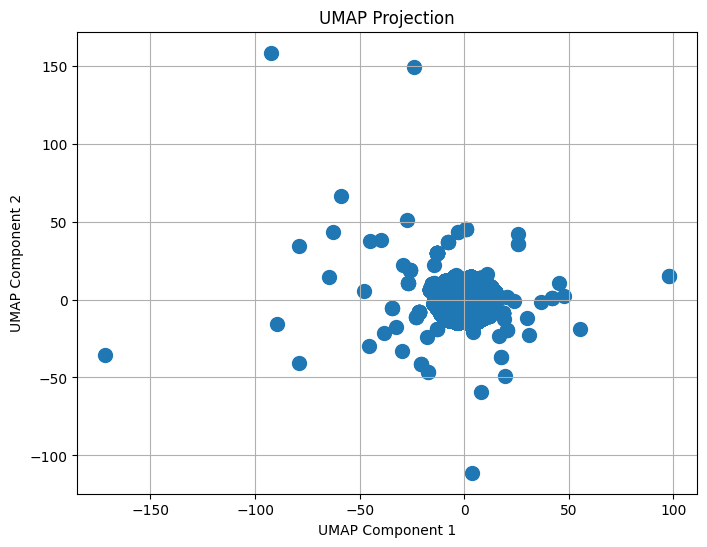

In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(df_embedding[:, 0], df_embedding[:, 1], s=100)
plt.title('UMAP Projection')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()

From this, it's clear that there is a single cluster of points in the center,
meaning that most of our observations could be combined together. There are some
points that are far away from the center, so perhaps these are outliers.

At this point, I apply HDBSCAN to cluster this embedded data, to hopefully
shine some further light into the data.

In [9]:
# Initialize HDBSCAN object, again with some starting parameters for this
# notebook
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10000,
    min_samples=40,
    gen_min_span_tree=True
)

# Fit the HDBSCAN model with the UMAP embedded data
clusterer.fit(df_embedding)

Number of clusters found: 12
Cluster labels: [10  0 -1 ... 10 10  5]


Now, I want to evaluate how well the clustering is. This is a bit open ended in nature, given that there is no pre-defined "true" label for the cluster.
Instead, I use a combination of 3 metrics to calculate a common score of sorts.

The first is the DBCV score. This measures how well points within each cluster
are clustered together, and how well separated individual clusters are. This
has a range of -1 to 1, with 1 having perfect clusters, 0 suggesting an ambigiuous cluster structure, and -1 indicating points likely being assigned to the wrong cluster - Ideal scores are positive as close to 1.

The second is the proportion of noise. This is just the proportion of our data that was considered an outlier by HDBSCAN. Lower is better, of course.

The third is the number of clusters. HDBSCAN is unique in that it will automatically determine the best number of clusters (compared to other algorithms where this is pre-defined), but we do not want to have a ton of clusters, which is quite possible with the scale of the data being used. To some degree, this wants to be minimized.

I define a custom metric combining all three as follows:
$$
\text{Score}_{\text{custom}} = (\text{Score}_{\text{DBCV}} - P_{\text{noise}}) - \alpha \cdot \ln(1 + N_{\text{clusters}})
$$
This subtracts the DBCV score with the proportion of noise, and then subtracts by a log transformation of the # of clusters. Given the range of all the other metrics, the range of my new custom metric is roughly negative infinity to 0.89 (this upper bound is with a DBCV score of 1, noise proportion of 0, and 2 clusters). In broader terms, the higher this custom score is, the better.

In [20]:
# Extract the cluster labels from the model
labels = clusterer.labels_

# Get DBCV score
dbcv_score = clusterer.relative_validity_

# Get noise proportion
noise_prop = np.sum(labels == -1) / len(labels)

# Get # of clusters
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Define a custom score combining the DBCV score, proportion of noise, and
# number of clusters
custom_score = (dbcv_score - noise_prop) - (0.1 * np.log1p(num_clusters))
print(f" Custom score (higher is better): {custom_score}")

12
 Custom score (higher is better): 0.4859672196438924


Overall, this is not too bad. Given the scale of the crime data I am using, I cannot realistically expect this to be very high, but at least for the static copy of the data stored from the previous notebook, this is fairly decent! More work can be done of course, but that's a whole other can of worms I will not worry about for now.

From here, I try to highlight each cluster with the UMAP embedded data.

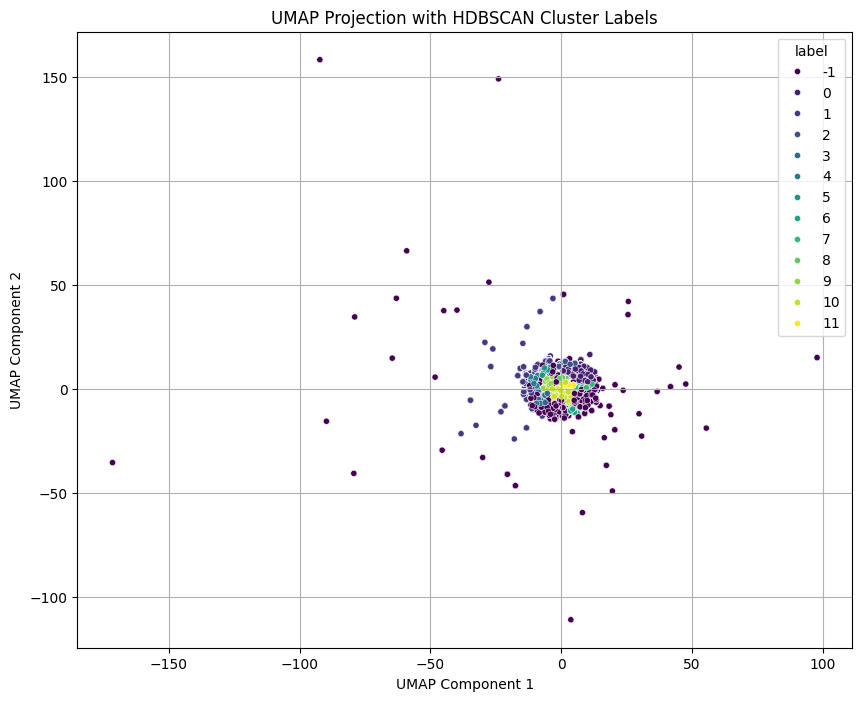

In [21]:
# Add the cluster labels to the UMAP embedded data
df_embedding_labeled = pd.DataFrame(df_embedding, columns=['UMAP Component 1', 'UMAP Component 2'])
df_embedding_labeled['label'] = labels

# Display the UMAP data with cluster labels
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='UMAP Component 1',
    y='UMAP Component 2',
    hue='label',
    data=df_embedding_labeled,
    palette='viridis',
    s=20,
    legend='full'
)
plt.title('UMAP Projection with HDBSCAN Cluster Labels')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()

Admittedly, this plot is not the best. Since there are so many clusters, it is hard to distinquish between them, especially since all the dots for this embedded data are with that one cluster in the center. What can be seen though, is that the distinquished clusters do have some form of cluster: Most of the green and yellow dots are right in the middle, with the green/blue dots around that, and the purple dots around that. This is good to verify that HDBSCAN is indeed working (e.g. having dots without any pattern of the color would be more concerning).

The final task now, is just adding the cluster labels back to the original dataframe.

In [24]:
# Adding a new cluster label column to the original dataframe, `df`, without the
# scaled data. This is for the final bit of EDA, and we do not want to perform
# that with the scaled data.

df['cluster_label'] = labels
print(df.head())

  dispatch_date       dispatch_time            address_block       lat  \
0    2025-05-02 2025-07-08 23:44:00      1100 BLOCK S 4TH ST -1.407757   
2    2025-04-23 2025-07-08 18:32:00     1700 BLOCK N 32ND ST -0.323392   
3    2025-04-24 2025-07-08 00:47:00  1300 BLOCK W Venango St  0.200477   
4    2025-02-26 2025-07-08 20:16:00      400 BLOCK N 35TH ST -0.805715   
5    2025-04-13 2025-07-08 03:15:00      5100 BLOCK N 5TH ST  0.681454   

        lon  district_01  district_02  district_03  district_05  district_06  \
0 -0.066541        False        False         True        False        False   
2 -0.628440        False        False        False        False        False   
3 -0.050807        False        False        False        False        False   
4 -0.732081        False        False        False        False        False   
5  0.231798        False        False        False        False        False   

   ...  min_temp_f  pop_total  income_median  median_age  poverty_rate  \


In [26]:
# Save the data with the cluster labels as a .pkl file
filepath = f"data/labeled_merged_data_2022-07-08_to_2025-07-07.pkl"
filepath = f"labeled_merged_data_2022-07-08_to_2025-07-07.pkl"
df.to_pickle(filepath)